In [1]:
from transformers import ViTForImageClassification

model0 = ViTForImageClassification.from_pretrained("./vit_model")

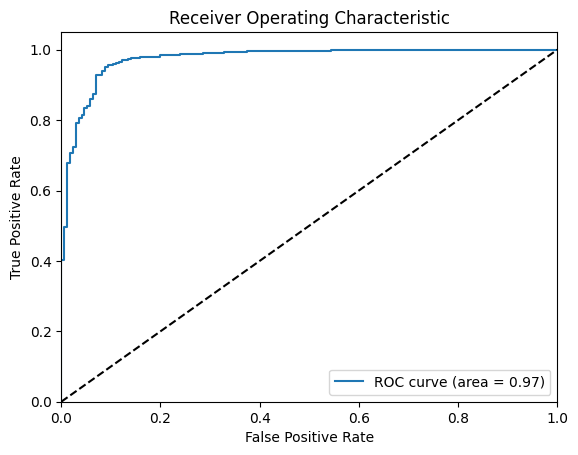

In [2]:
import torch
import accelerate
from torch.utils.data import DataLoader
from torchvision.transforms import (
    Compose, Resize, ToTensor, Normalize
)
from transformers import ViTConfig, ViTForImageClassification, Trainer, TrainingArguments
from datasets import DatasetDict

import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

dataset = DatasetDict.load_from_disk("./chest_xray_clasnsificatio")

image_size = 224
transforms = Compose([
    Resize((image_size, image_size)),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def preprocess_data(example):
    example['pixel_values'] = transforms(example['image'])
    return example

dataset = dataset.map(preprocess_data, batched=False)

dataset = dataset.remove_columns(["image_file_path", "image"])


test_dataset = dataset["test"]
logits, labels = [], []

for i in range(len(test_dataset)):
    inputs = torch.tensor(test_dataset[i]["pixel_values"]).unsqueeze(0)
    with torch.no_grad():
        output = model0(inputs)
    logits.append(output.logits.squeeze(0).numpy())
    labels.append(test_dataset[i]["labels"])

logits = np.array(logits)
labels = np.array(labels)


if logits.shape[1] > 1:  
    probs = torch.softmax(torch.tensor(logits), dim=1).numpy()[:, 1] 
else: 
    probs = torch.sigmoid(torch.tensor(logits)).numpy().flatten()
    
predictions = (probs > 0.5).astype(int)
fpr, tpr, thresholds = roc_curve(labels, probs)
roc_auc = roc_auc_score(labels, probs)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [3]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
predicted_labels=predictions
f1 = f1_score(labels, predicted_labels, average='binary')
accuracy = accuracy_score(labels, predicted_labels)
precision = precision_score(labels, predicted_labels, average='binary')
recall = recall_score(labels, predicted_labels, average='binary')
conf_matrix = confusion_matrix(labels, predicted_labels)

print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(labels, predicted_labels))

F1 Score: 0.96
Accuracy: 0.94
Precision: 0.95
Recall: 0.97

Confusion Matrix:
[[149  22]
 [ 12 399]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       171
           1       0.95      0.97      0.96       411

    accuracy                           0.94       582
   macro avg       0.94      0.92      0.93       582
weighted avg       0.94      0.94      0.94       582

